In [98]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [99]:
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

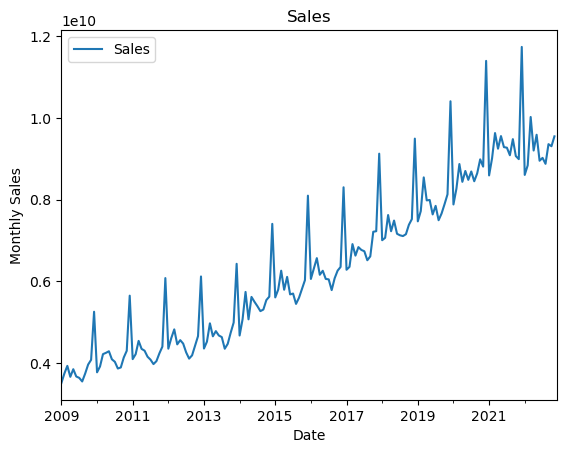

In [100]:
df = pd.read_csv("../public/seijyo_ishii_monthly_sales.csv", index_col='Month', parse_dates=True)
df.plot()
plt.title('Sales')
plt.ylabel('Monthly Sales')
plt.xlabel('Date')
plt.show()

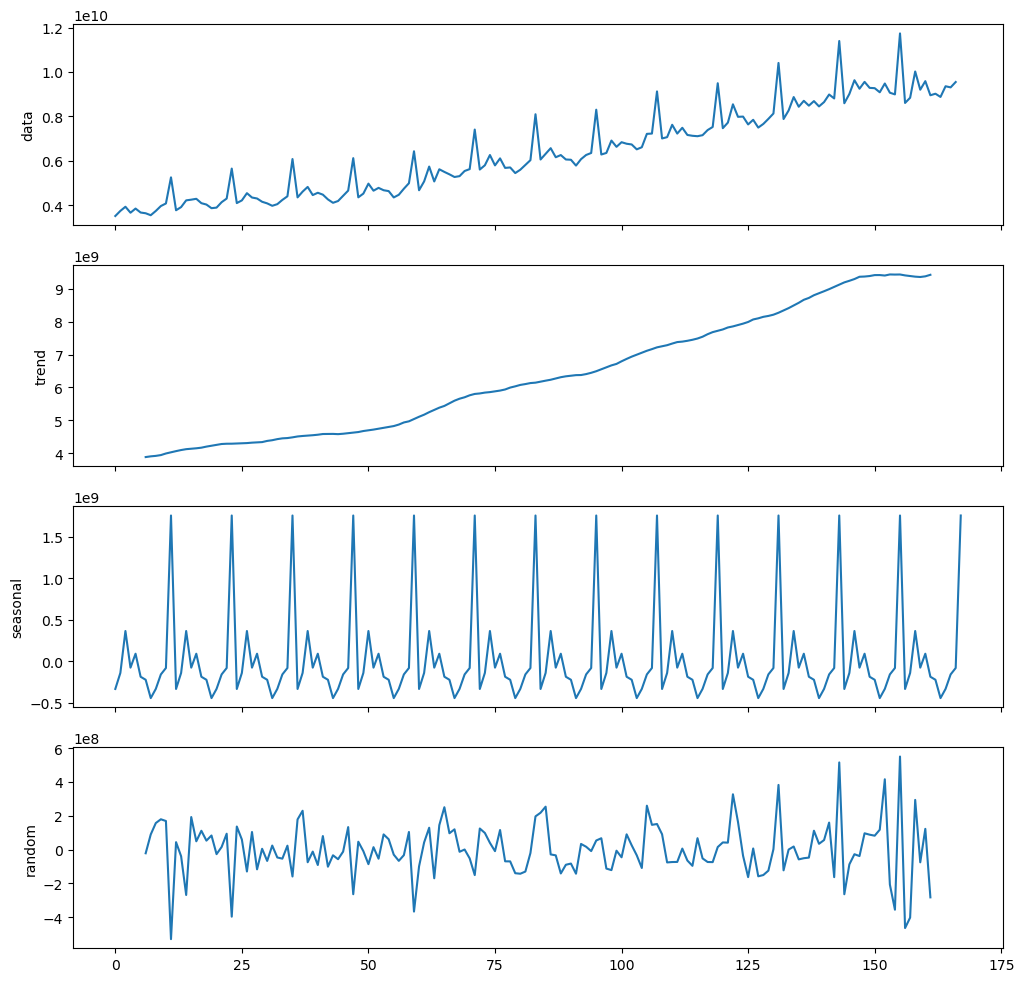

In [101]:
# 成分分解

data = df.Sales.values

utils.decomposed_plot(arima.decompose(data,'additive',m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

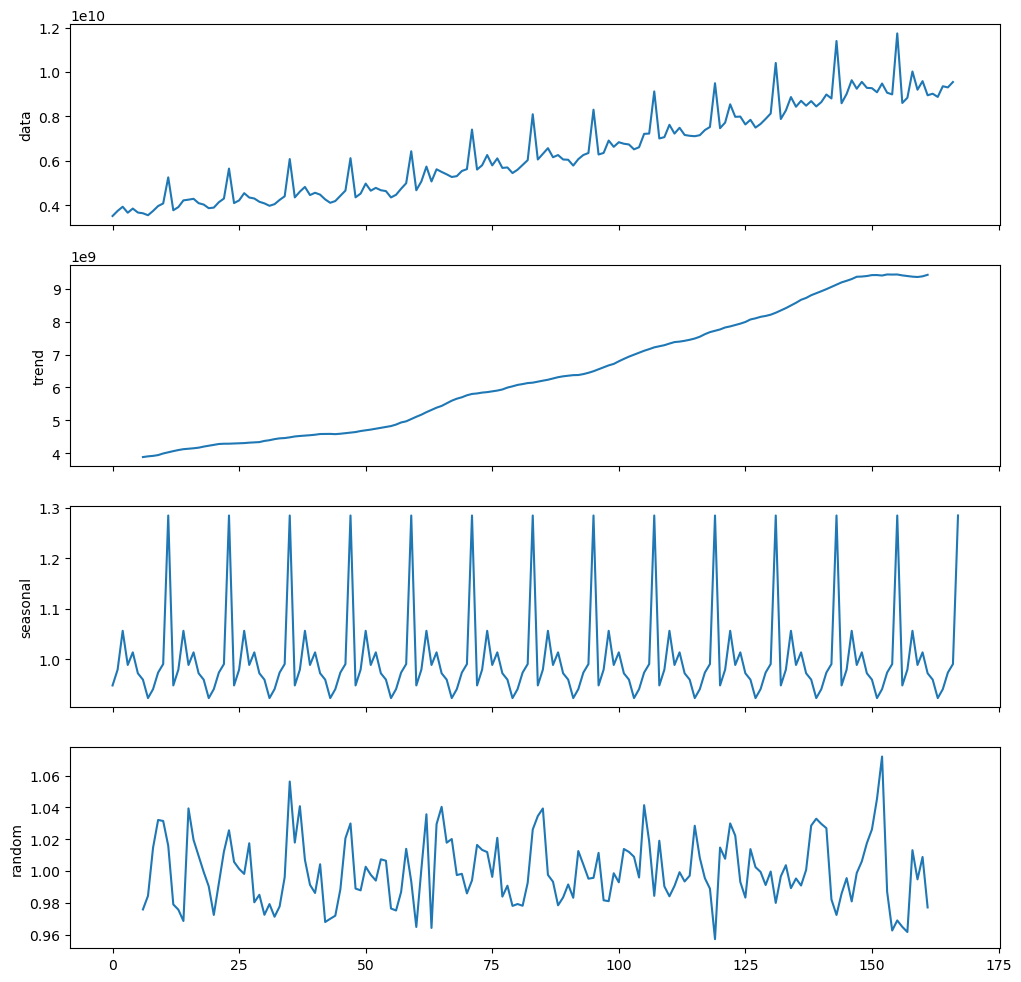

In [102]:
utils.decomposed_plot(arima.decompose(data,'multiplicative',m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

In [103]:
# 乗法モデルを採用する。

<AxesSubplot:xlabel='Month'>

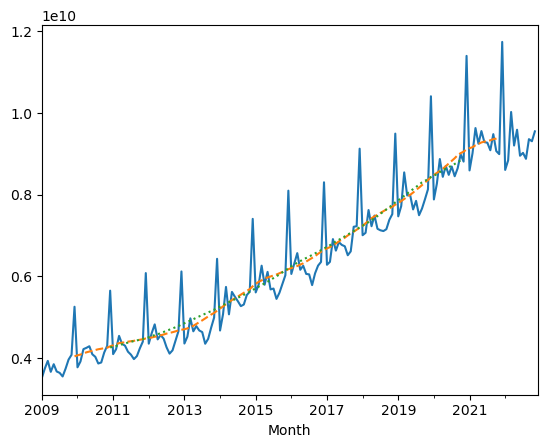

In [104]:
df.Sales.plot()
df.Sales.rolling(24).mean().shift(-12).plot(style='--')
df.Sales.rolling(48).mean().shift(-24).plot(style=':')

In [105]:
# SARIMAX(手動構築)を適用する

In [106]:
# 前半120時点を学習用データとして、残りを検証用データとする。
df_train = df[:120]
df_test = df[120:156]

In [107]:
# 階差の次数を検討する。
print('d =', arima.ndiffs(df_train))      #d
print('D =',arima.nsdiffs(df_train,m=12)) #D

d = 1
D = 1


In [108]:
# 階差の次数が1、季節階差の次数も1と決定。

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


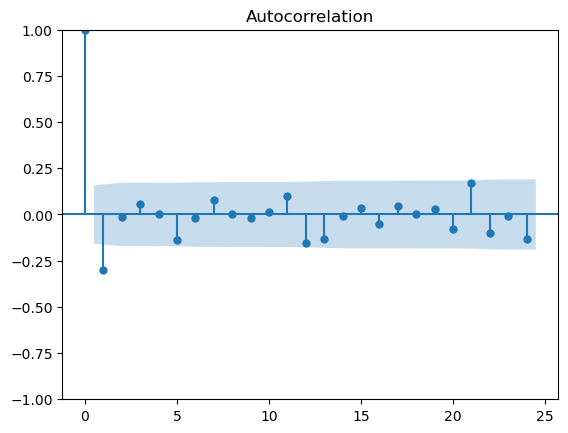

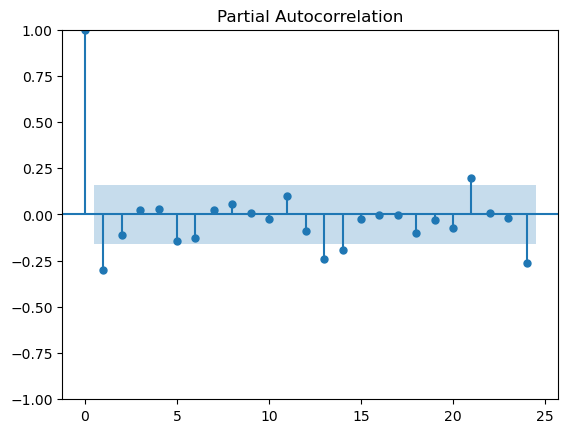

In [109]:
# 前期との差分から階差系列(1次)、12期前(1年前)との差分から季節階差系列(1次)を求める。
# またコレログラムも求める。

# コレログラム（自己相関と偏自己相関）
data = df.diff(1).diff(12).dropna()
utils.plot_acf(data, alpha=.05, lags=24)
utils.plot_pacf(data, alpha=.05, lags=24)

In [110]:
# SARIMAXの次数を機械的に与える。
# 一旦ARとMAの次数を1として、進める。
# SARIMAXのAR=1, d=1, MA=1, 季節AR=0, 季節階差D=1, 季節MA=0

In [111]:
# 学習
sarima_model = SARIMAX(df_train, order=(1, 1, 1),  seasonal_order=(0, 1, 0,12))
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85276D+01    |proj g|=  2.89538D+00

At iterate    5    f=  1.80969D+01    |proj g|=  2.13654D-02

At iterate   10    f=  1.80938D+01    |proj g|=  5.30878D-02

At iterate   15    f=  1.80932D+01    |proj g|=  2.76025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   3.065D-06   1.809D+01
  F =   18.093166060231656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [112]:
# 予測
##学習データの期間の予測値
train_pred = sarima_fit.predict()
##テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
##予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
665713105.0298227
MAE:
573966290.9590483
MAPE:
0.06293315571015012


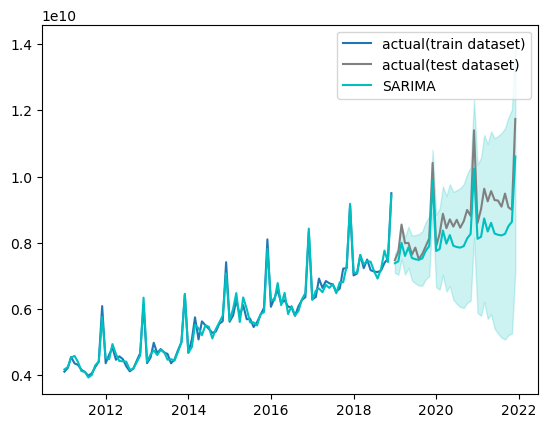

In [113]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color='c',
    alpha=.2)
ax.legend()

In [114]:
# pmdarimaのauto_arima関数を使って、ARIMAモデルを自動構築する。

arima_model = pm.auto_arima(df_train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=4355.068, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4345.967, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4349.320, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4349.675, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=4347.238, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4347.461, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=4349.457, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4347.389, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4347.746, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4348.516, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=4347.232, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.902 seconds


In [115]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
668243667.3159982
MAE:
576395540.8611112
MAPE:
0.06320459559355458


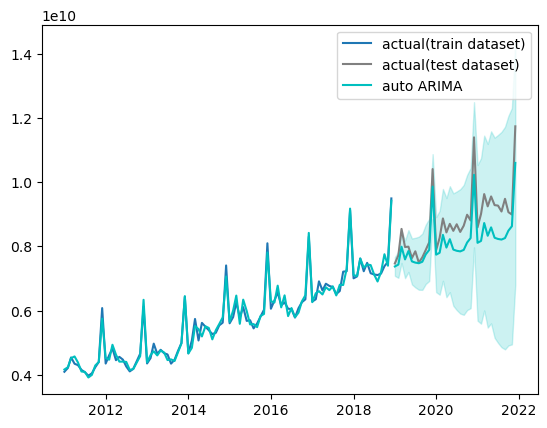

In [116]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

In [117]:
# 原系列を対数変換し、対数系列を作成

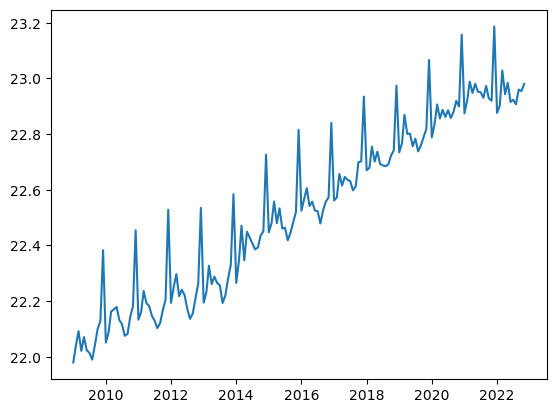

In [118]:
# 対数変換
df_log = np.log(df)
# 系列のプロット
plt.plot(df_log)

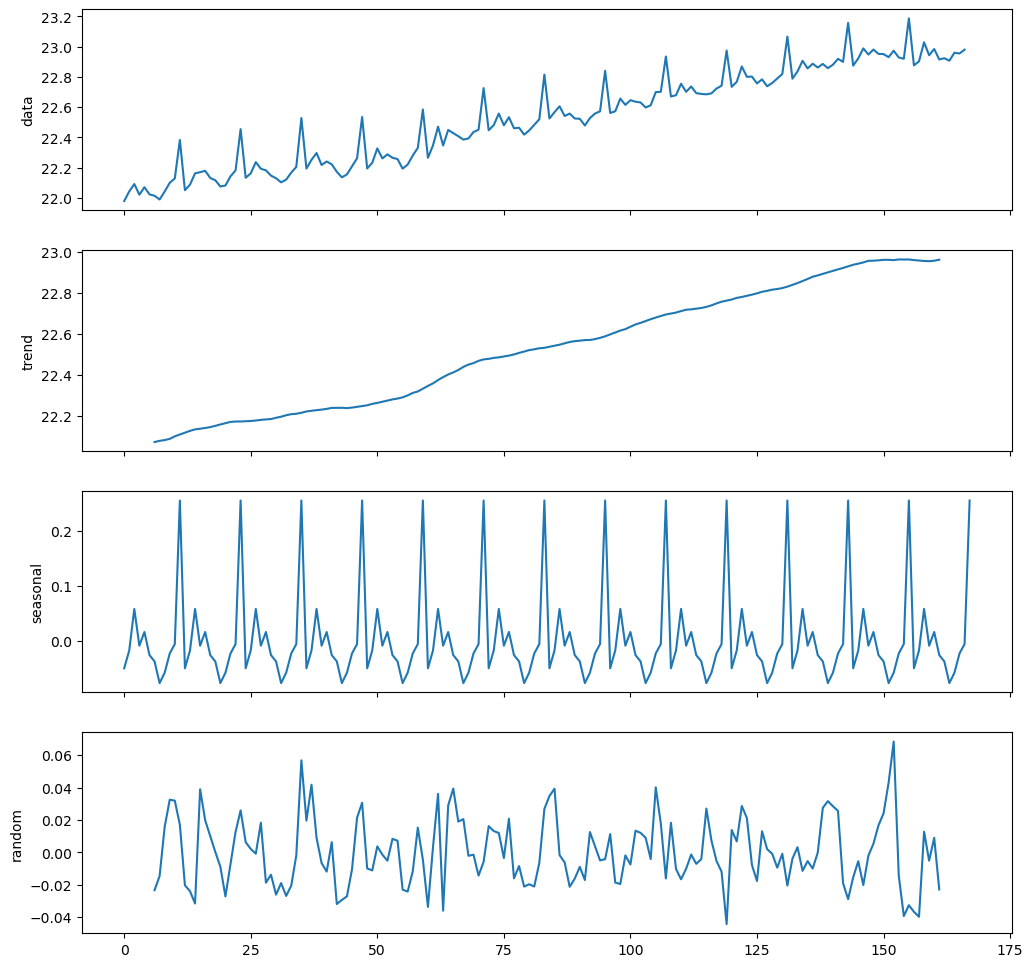

In [119]:
# 成分分解（tread・seasonal・random）
data = df_log.Sales.values
utils.decomposed_plot(arima.decompose(data,'additive',m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

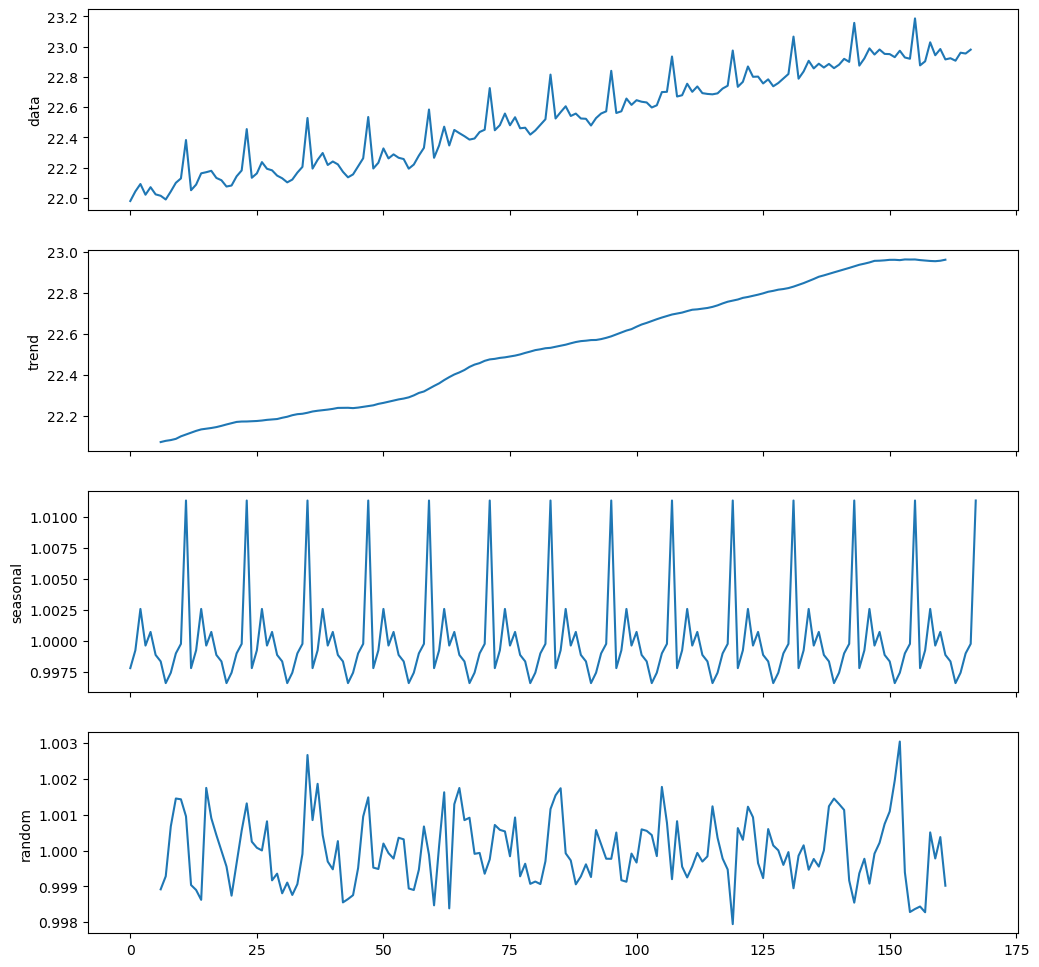

In [120]:
# 成分分解（tread・seasonal・random）
data = df_log.Sales.values
utils.decomposed_plot(arima.decompose(data,'multiplicative',m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

In [121]:
# 前半120時点を学習用データとして、残りを検証用データとする。
df_log_train = df_log[:120]
df_log_test = df_log[120:156]

In [122]:
# 階差の次数の検討
print('d =', arima.ndiffs(df_log_train))
print('D =', arima.nsdiffs(df_log_train, m=12))

d = 1
D = 0


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


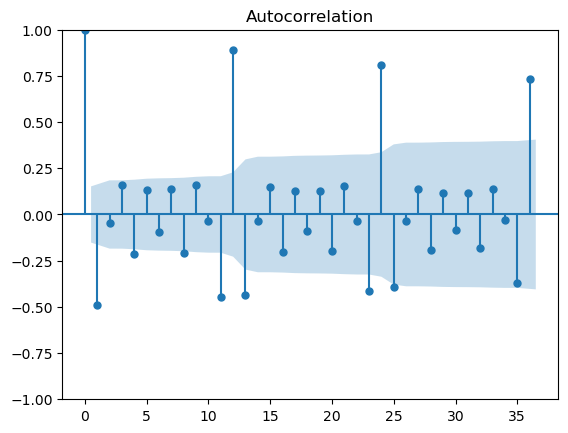

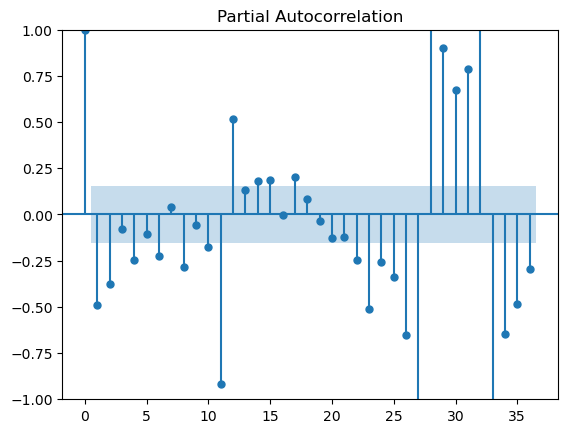

In [123]:
# 前期との差分から階差系列(1次)、12期前(1年前)との差分から季節階差系列(1次)を求める。
# またコレログラムも求める。

# コレログラム（自己相関と偏自己相関）
log_data = df_log.diff(1).dropna()
utils.plot_acf(log_data, alpha=.05, lags=36)
utils.plot_pacf(log_data, alpha=.05, lags=36)

In [124]:
# 学習
sarima_model = SARIMAX(df_log_train, order=(1, 1, 1),  seasonal_order=(0, 1, 0,12))
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93301D+00    |proj g|=  1.89542D+00

At iterate    5    f= -1.93372D+00    |proj g|=  7.70007D-02

At iterate   10    f= -1.93388D+00    |proj g|=  1.68676D-01

At iterate   15    f= -1.93389D+00    |proj g|=  3.90010D-02

At iterate   20    f= -1.93487D+00    |proj g|=  7.85574D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     36      1     0     0   4.154D-02  -1.936D+00
  F =  -1.9356686236199181     

CONVERG

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [125]:
# 予測
##学習データの期間の予測値
train_pred = sarima_fit.predict()
##テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_log_test))
##予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_log_test)).conf_int() 
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_log_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_log_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_log_test, test_pred))

RMSE:
0.08234996089205471
MAE:
0.07372531637722732
MAPE:
0.0032167080701967486


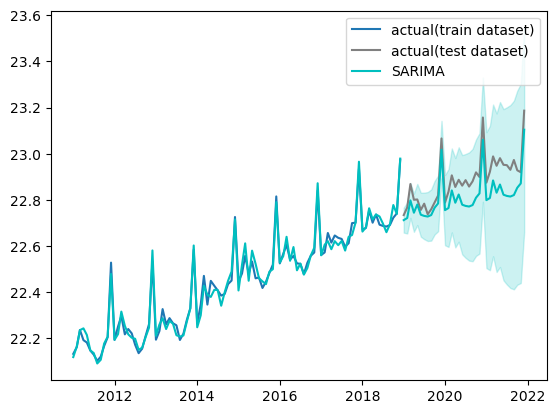

In [126]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_log_train[24:].index, df_log_train[24:].values, label="actual(train dataset)")
ax.plot(df_log_test.index, df_log_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_log_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_log_test.index, test_pred.values, label="SARIMA", color="c") 
ax.fill_between(
    df_log_test.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color='c',
    alpha=.2)
ax.legend()

In [127]:
# pmdarimaのauto_arima関数を使って、ARIMAモデルを自動構築する。

arima_model = pm.auto_arima(df_log_train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-456.959, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-157.171, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-300.773, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-158.622, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-300.621, Time=0.11 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-450.683, Time=0.19 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-450.372, Time=0.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-449.126, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-202.900, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-348.126, Time=0.40 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-458.882, Time=0.45 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-459.961, Time=0.23 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-451.162, Time=0.13 sec
 ARIMA(1,1,2)(2,0,1)[12]

In [128]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_log_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_log_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_log_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_log_test, test_pred))

RMSE:
0.05375319073848181
MAE:
0.04570247923689921
MAPE:
0.001993548131013052


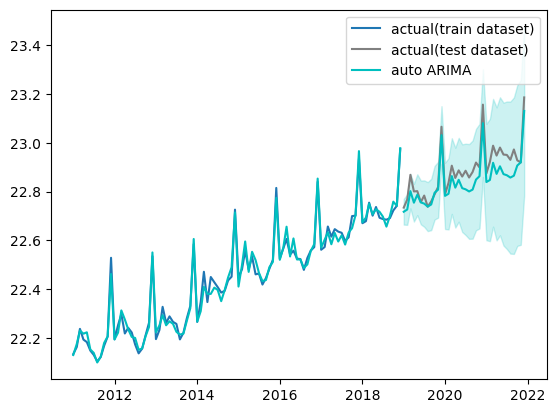

In [140]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_log_train[24:].index, df_log_train[24:].values, label="actual(train dataset)")
ax.plot(df_log_test.index, df_log_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_log_train[24:].index, train_pred[24:], color="c")
ax.plot(df_log_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_log_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

In [141]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(df_log_train, 
                            seasonal=True,
                            m=12,
                            d=1,
                            D=0,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-456.959, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-157.171, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-300.773, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-158.622, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-300.621, Time=0.45 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-450.683, Time=0.25 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-450.372, Time=0.48 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-449.126, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-202.900, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-348.126, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-458.882, Time=0.36 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-459.961, Time=0.22 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-451.162, Time=0.14 sec
 ARIMA(1,1,2)(2,0,1)[12]

In [142]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_log_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_log_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_log_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_log_test, test_pred))

RMSE:
0.05375319073848181
MAE:
0.04570247923689921
MAPE:
0.001993548131013052


In [143]:
train_pred

array([ 0.        , 21.97937699, 22.02403553, 22.06666835, 22.0338085 ,
       22.05942629, 22.03450011, 22.02251013, 22.00200227, 22.02981191,
       22.07364466, 22.10355147, 22.25451891, 22.11831853, 22.14401285,
       22.09083756, 22.18871818, 22.13436134, 22.1241111 , 22.09627489,
       22.13266083, 22.15452861, 22.17616627, 22.41935374, 22.1291439 ,
       22.17453424, 22.22943007, 22.21663879, 22.22240753, 22.15186683,
       22.13795448, 22.09853461, 22.12282429, 22.17885545, 22.20544767,
       22.46179564, 22.19298813, 22.22119899, 22.31224987, 22.27499931,
       22.23437996, 22.20342458, 22.19923023, 22.15052023, 22.15590192,
       22.20532314, 22.24462707, 22.55014514, 22.22220264, 22.25098638,
       22.29271375, 22.25120826, 22.26767342, 22.25694567, 22.22441139,
       22.21294286, 22.2169531 , 22.26915475, 22.32169106, 22.60536463,
       22.26608228, 22.30912122, 22.40885878, 22.38000616, 22.37998742,
       22.40576599, 22.3963272 , 22.35019869, 22.39609294, 22.44

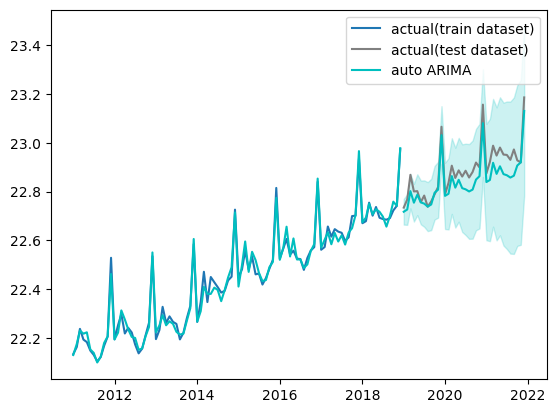

In [144]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_log_train[24:].index, df_log_train[24:].values, label="actual(train dataset)")
ax.plot(df_log_test.index, df_log_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_log_train[24:].index, train_pred[24:], color="c")
ax.plot(df_log_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_log_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()